# Demonstrate Positional Bias

Our goal here is to quantify positional bias inherrent in our LLM.

# Setup

In [1]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import partial
import json
import logging
from pathlib import Path
from time import perf_counter_ns as timer

from pandas import DataFrame
import rich
from rich.table import Table
from tqdm import tqdm

import llm_mcq_bias as lmb
from llm_mcq_bias.datasets.mmlu import Evaluation, OPTIONS

In [2]:
def print_table(rows, title: str | None = None):
    table = Table(*[k for k in rows[0]], title=title, box=rich.box.SIMPLE)
    for row in rows:
        table.add_row(*[str(v) for v in row.values()])
    rich.print(table)

In [3]:
project_path = Path("../")
datasets_path = project_path / ".build" / "datasets"

logger = logging.getLogger(__name__)

# Demonstrate Bias

In [4]:
# Number of iterations
n_epochs = 10

# Number of questions to sample
n_questions = 160

# Number of workers
n_jobs = 3

# Model
model = "gemma2:9b"

options = {
    # Limit output tokens to avoid waiting for invalid responses
    "num_predict": 10,
    # Disable token sampling
    "top_k": 1,
}

generator = partial(lmb.models.ollama, model=model, options=options)

In [5]:
# Load example questions
examples = lmb.datasets.mmlu.load_dataset(datasets_path, segment="dev")

# Debias example answer distribution
examples = lmb.datasets.mmlu.normalize_example_answers(examples)

# Load test questions
questions = lmb.datasets.mmlu.load_dataset(datasets_path, segment="test")

# Initialize thread pool
executor = ThreadPoolExecutor(max_workers=n_jobs)

In [6]:
def process_mcq(mcq):
    # Generate prompt
    prompt = lmb.datasets.mmlu.generate_prompt(examples, mcq)

    # Generate answer
    response = generator(prompt=prompt)

    # Evaluate response
    return lmb.datasets.mmlu.evaluate_response(mcq, response)


def benchmark(
    description: str,
    *,
    examples: DataFrame,
    questions: DataFrame,
):
    n = len(questions)

    start_time = timer()

    # Answer and evaluate each question
    futures = [executor.submit(process_mcq, mcq) for _, mcq in questions.iterrows()]

    # Collect results
    correct, errors = 0, 0
    for future in tqdm(as_completed(futures), total=n, desc=description):
        evaluation = future.result()
        if evaluation is Evaluation.CORRECT:
            correct += 1
        elif evaluation is Evaluation.ERROR:
            errors += 1

    duration = timer() - start_time

    # Derive metrics
    metrics = {
        "n": n,
        "correct": correct,
        "errors": errors,
        "accuracy": correct / (n - errors),
        "error_rate": errors / n,
        "rps": 1000000000 * n / duration,
    }

    return metrics

### Verify Stable Benchmark Results

Let's make sure our benchmark process produces consistent results when run against the same inputs.

<Axes: xlabel='answer'>

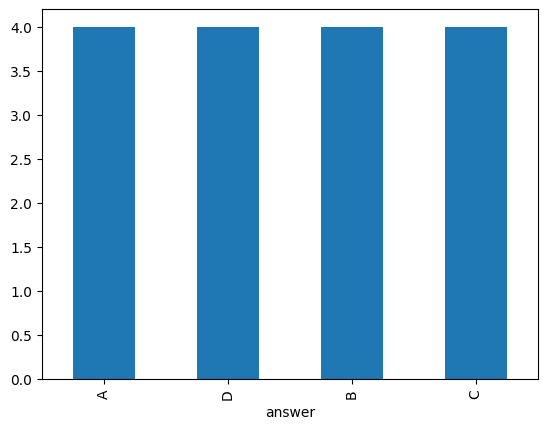

In [7]:
# Sample questions
selected_questions = questions.sample(n=16)

# Debias answer distribution
selected_questions = lmb.datasets.mmlu.normalize_question_answers(selected_questions)

# Plot answer distribution
selected_questions.answer.value_counts().plot.bar()

In [8]:
# Print example prompt
print(lmb.datasets.mmlu.generate_prompt(examples, selected_questions.iloc[0]))

You are a robot that only outputs JSON. You reply in JSON format with the field 'answer'. For example, the following are multiple choice questions about college biology.

Example Question: In a given population, 1 out of every 400 people has a cancer caused by a completely recessive allele, b. Assuming the population is in Hardy-Weinberg equilibrium, which of the following is the expected proportion of individuals who carry the b allele but are not expected to develop the cancer?

A) 38/400
B) 19/400
C) 20/400
D) 1/400

Example Answer: {"answer": "A"}

Example Question: Which of the following represents an accurate statement concerning arthropods?

A) They possess an exoskeleton composed primarily of peptidoglycan.
B) They possess an open circulatory system with a dorsal heart.
C) They are members of a biologically unsuccessful phylum incapable of exploiting diverse habitats and nutrition sources.
D) They lack paired, jointed appendages.

Example Answer: {"answer": "B"}

Example Questi

In [9]:
%%time

rows = []
for i in range(3):
    # Run benchmark
    metrics = benchmark(
        f"epoch {i}",
        examples=examples,
        questions=selected_questions,
    )

    rows.append(metrics)

print_table(rows)

epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:50<00:00,  3.14s/it]


 n    correct   errors   accuracy             error_rate   rps                  
 ─────────────────────────────────────────────────────────────────────────────── 
  16   10        2        0.7142857142857143   0.125        0.28330335766344417  
  16   10        2        0.7142857142857143   0.125        0.31937940943653764  
  16   10        2        0.7142857142857143   0.125        0.31826778035538117

CPU times: user 227 ms, sys: 19.2 ms, total: 246 ms
Wall time: 2min 36s


## Estimate Positional Bias

In [ ]:
%%time

# Repeat over multiple iterations
rows = []
for _ in range(n_epochs):
    # Sample questions
    selected_questions = questions.sample(n=n_questions)

    # Debias answer distribution
    selected_questions = lmb.datasets.mmlu.normalize_question_answers(
        selected_questions
    )

    # Initialize metrics
    metrics = {}

    # Record performance w/ original data
    metrics["uniform"] = benchmark(
        "uniform",
        examples=examples,
        questions=selected_questions,
    )

    # Record performance w/ answers shifted to each position
    for option in OPTIONS:
        # Swap answers to selected option
        q = lmb.datasets.mmlu.swap_options(selected_questions, option)

        metrics[option] = benchmark(
            option,
            examples=examples,
            questions=q,
        )

    rows.append(metrics)

uniform:  12%|█████████████████▉                                                                                                                             | 20/160 [01:17<08:38,  3.70s/it]

In [ ]:
table = Table("uniform", "A", "B", "C", "D", box=rich.box.SIMPLE)
for row in rows:
    baseline = row["uniform"]["accuracy"]
    offsets = {k: row[k]["accuracy"] - baseline for k in OPTIONS}
    colors = {option: "black" for option in OPTIONS}
    colors |= {option: "red" for option in OPTIONS if offsets[option] <= -0.05}
    colors |= {option: "green" for option in OPTIONS if offsets[option] >= 0.05}
    table.add_row(
        f"{baseline:0.2f}",
        f"[{colors['A']}]{offsets['A']:0.2f}[/{colors['A']}]",
        f"[{colors['B']}]{offsets['B']:0.2f}[/{colors['B']}]",
        f"[{colors['C']}]{offsets['C']:0.2f}[/{colors['C']}]",
        f"[{colors['D']}]{offsets['D']:0.2f}[/{colors['D']}]",
    )

rich.print(table)

# Export Results

In [ ]:
path = Path("results/demonstrate-bias-gemma2-160-10epochs-run1.json")
path.write_text(json.dumps(rows))